In [1]:
import cv2
import json
import os
import random
import requests
import skimage
import sys
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from functions.extract_images import extract_images
from functions.utils import get_classes, show_annotations, get_api_key
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from scripts.amg import write_masks_to_folder
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)  
    
random.seed(42)
np.random.seed(42)

### 1. Load your image

Would you like to load image ./test_images/sandwich.jpg?

Type 'y' or alternative file path: 
y

Loading image ./test_images/sandwich.jpg


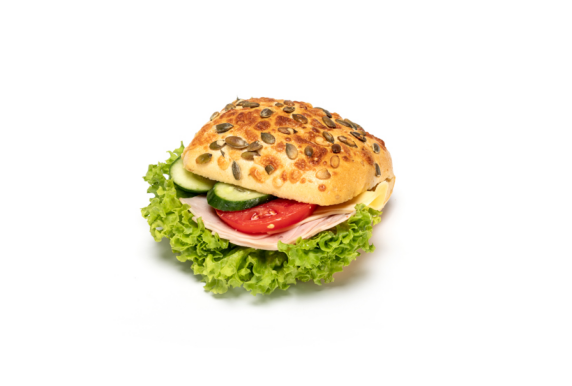

In [2]:
# Load image for segmentation
file_name = "sandwich"
extension = ".jpg"
image_path = f"./test_images/{file_name}{extension}"

prompt = f"""Would you like to load image {image_path}?\n
Type 'y' or alternative file path: \n"""
answer = input(prompt).lower()

if answer != 'y':
    image_path = answer
    
print(f"\nLoading image {image_path}")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

### 2. Segment your image with SAM

Generated 17 masks. You will be able to revise the selection.


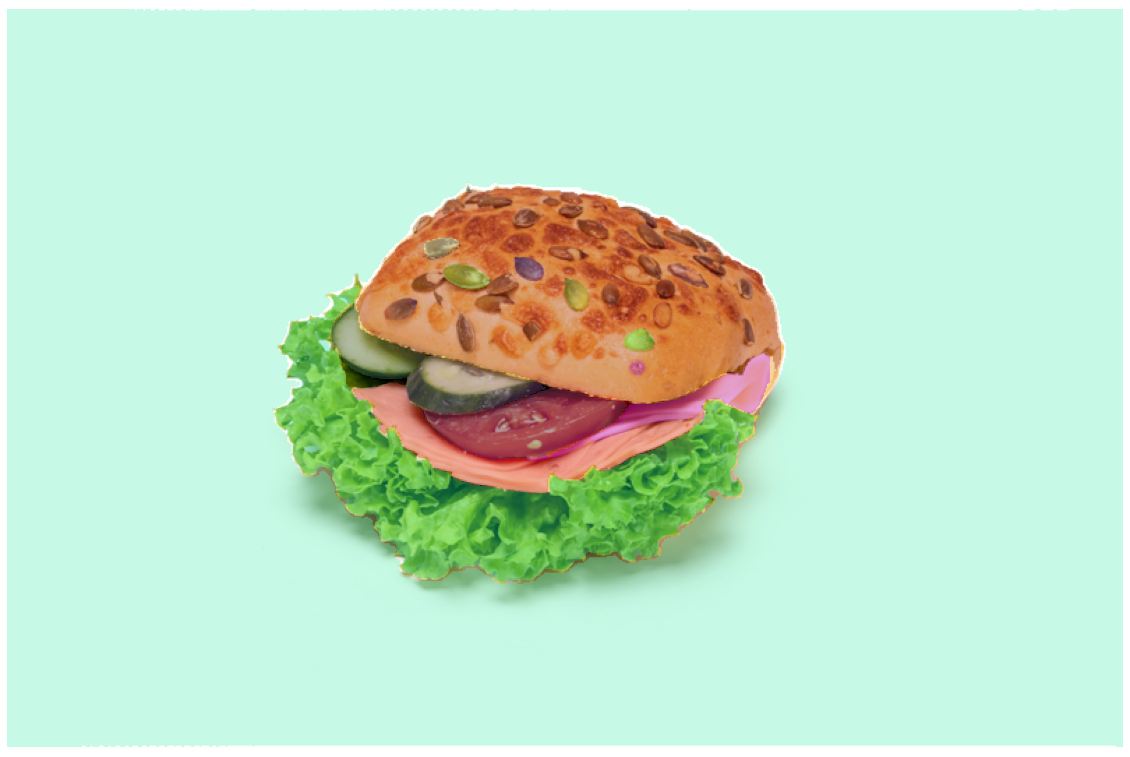

In [3]:
# Create masks with Segment Anything Model
checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device=device)

# SAM is unfortunately very sensitive to hyper-parameters so this is likely not the best choice
# for other images that one would want to segment
mask_generator = SamAutomaticMaskGenerator(model=sam, points_per_side=24, pred_iou_thresh=0.96, min_mask_region_area=300)

masks = mask_generator.generate(image)
print(f"Generated {len(masks)} masks. You will be able to revise the selection.")

# Show image
plt.figure(figsize=(20,20))
plt.imshow(image)
show_annotations(masks)
plt.axis("off")
plt.show()

# Save masks
session = f"{file_name}_{int(time.time())}"
mask_path = f"temp/{session}/"
os.makedirs(mask_path, exist_ok=True)
write_masks_to_folder(masks, mask_path)

### 3. Verify correctness of masks

In [4]:
%%capture

# Extract masks from original image
processed_path = f"temp/{session}/extracted"
segmented_images = extract_images(mask_path, image_path, processed_path)
segmented_images = sorted(segmented_images, key=lambda t: t[0])
segmented_images = [image for (index, image) in segmented_images]

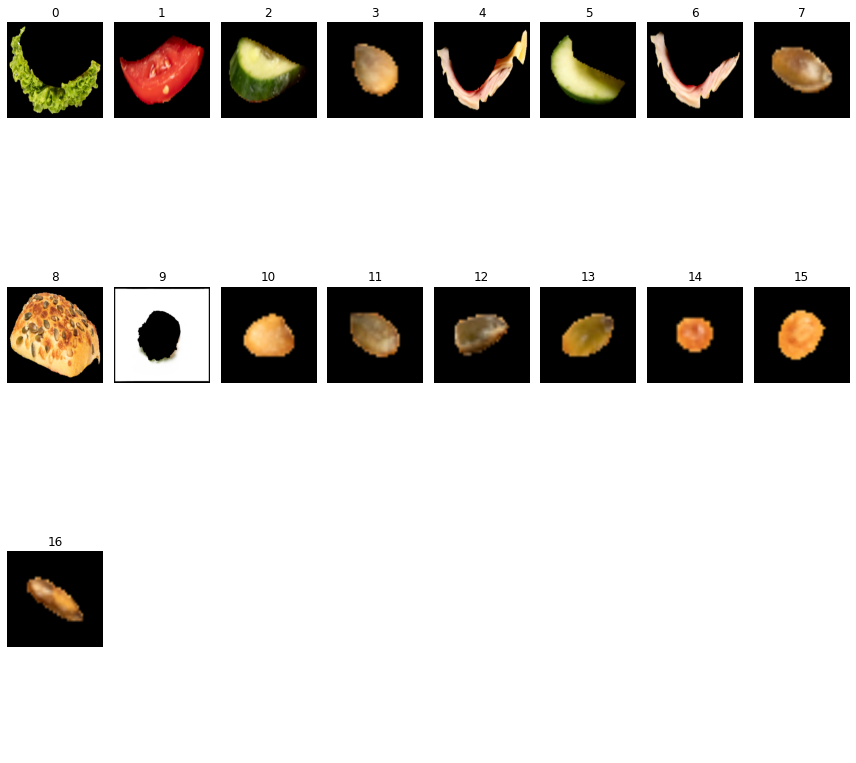

In [5]:
# Present masks to user
grid_length = int(np.ceil(len(segmented_images) / 8))
fig, axes = plt.subplots(grid_length, 8, figsize=(12, 12))

for index, ax in enumerate(axes.reshape(-1)): 
    if index >= len(segmented_images):
        ax.set_axis_off()
        continue
        
    ax.set_title(str(index))
    ax.set_axis_off()
    ax.imshow(segmented_images[index])

fig.tight_layout()
plt.show()

**We find that SAM has created a mask for the background (9) and a duplicate mask with ham (4 and 6) so we will exclude those.**  
**We will also remove the masks for the seeds as they do not exist in our dataset (SAM post-processing seems not to work)**

Would you like to exclude any masks from further processing?

Input them in the format '0 5 12' (if any):
3 4 7 9 10 11 12 13 14 15 16


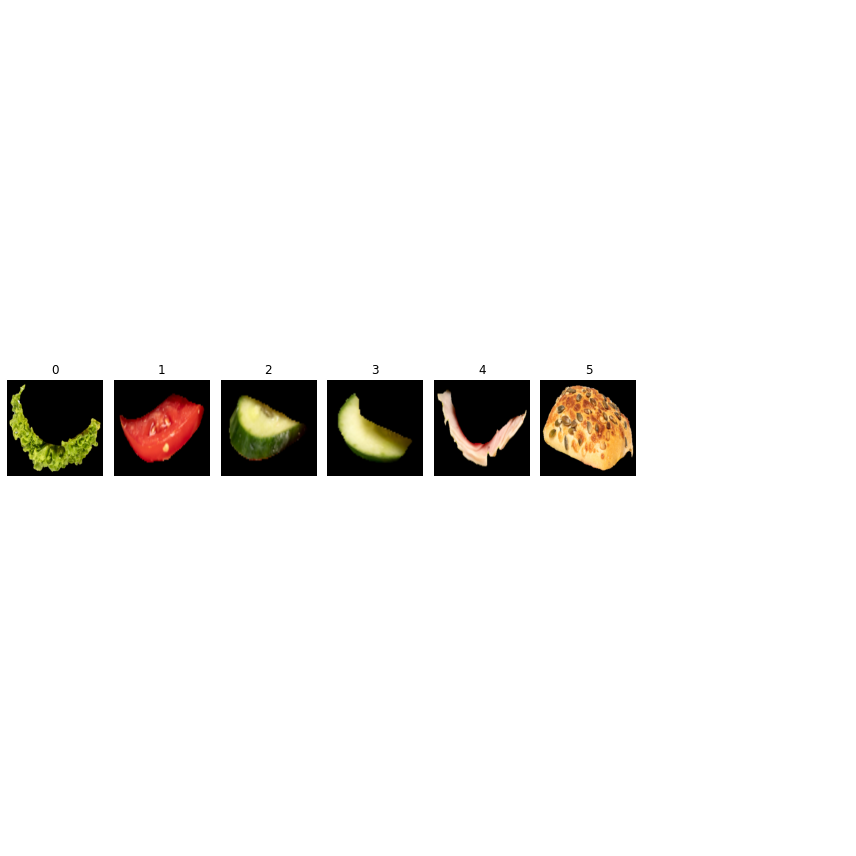

In [6]:
# Allow user to exclude certain masks
prompt = f"""Would you like to exclude any masks from further processing?\n
Input them in the format '0 5 12' (if any):\n"""
answer = input(prompt).lower()
answer = [int(index) for index in answer.split(" ")]

mask_map = {}
processed_images = []

for index, img in enumerate(segmented_images):
    if index not in answer:
        mask_map[len(processed_images)] = index
        processed_images.append(img)

segmented_images = processed_images
grid_length = int(np.ceil(len(segmented_images) / 8))
fig, axes = plt.subplots(grid_length, 8, figsize=(12, 12))

for index, ax in enumerate(axes.reshape(-1)): 
    if index >= len(segmented_images):
        ax.set_axis_off()
        continue
        
    ax.set_title(str(index))
    ax.set_axis_off()
    ax.imshow(segmented_images[index])

fig.tight_layout()
plt.show()

### 4. Run classification

In [7]:
%%capture

# Run inference on fine-tuned ResNet50
model  = resnet50(weights=ResNet50_Weights)

model.fc = torch.nn.Linear(model.fc.in_features, 43)
model.fc.load_state_dict(torch.load("models/linear_v2.pth"))

tf = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(224)])

classes = get_classes()
predictions = []

with torch.no_grad():
    model.eval()
    
    for segment in segmented_images:
        out = model(tf(segment).float().unsqueeze(0))
        y_pred = torch.argmax(out).item()
        predictions.append(classes[y_pred])

### 5. Verify correctness of predictions

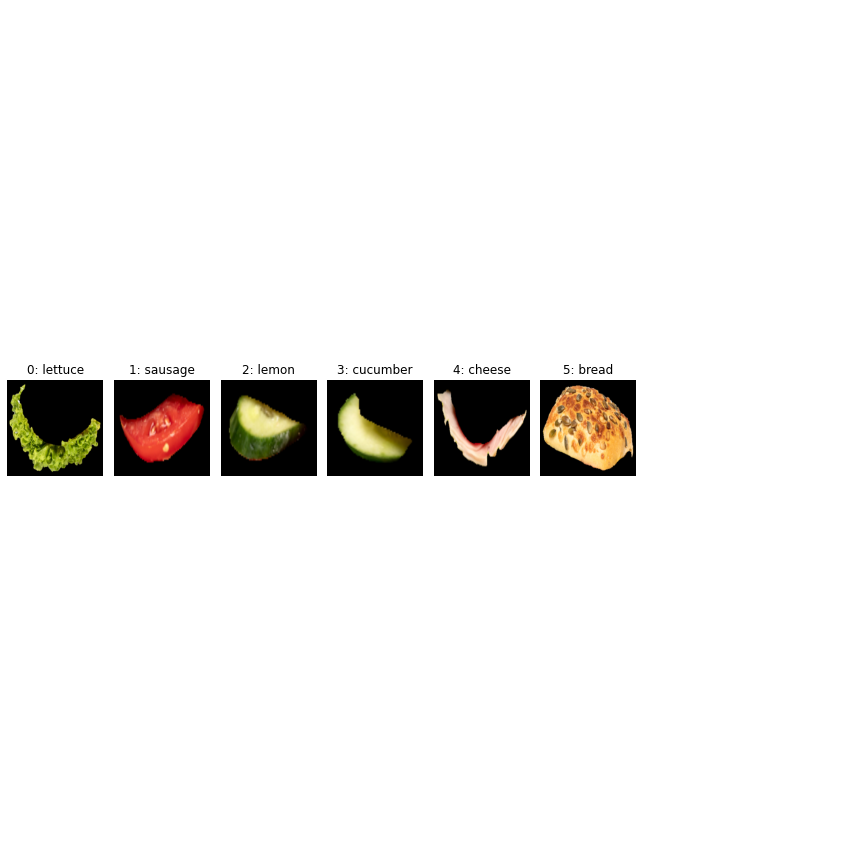

In [8]:
# Output images with predicted classes
fig, axes = plt.subplots(grid_length, 8, figsize=(12, 12))

for index, ax in enumerate(axes.reshape(-1)): 
    if index >= len(segmented_images):
        ax.set_axis_off()
        continue
        
    ax.set_title(f"{index}: {predictions[index]}")
    ax.set_axis_off()
    ax.imshow(segmented_images[index])

fig.tight_layout()
plt.show()

**We need to fix some classifications**

Would you like to redefine any of the masks?

Input them in the format '0:apple 5:pear 12:banana' (if any):
1:tomato 2:cucumber 4:ham


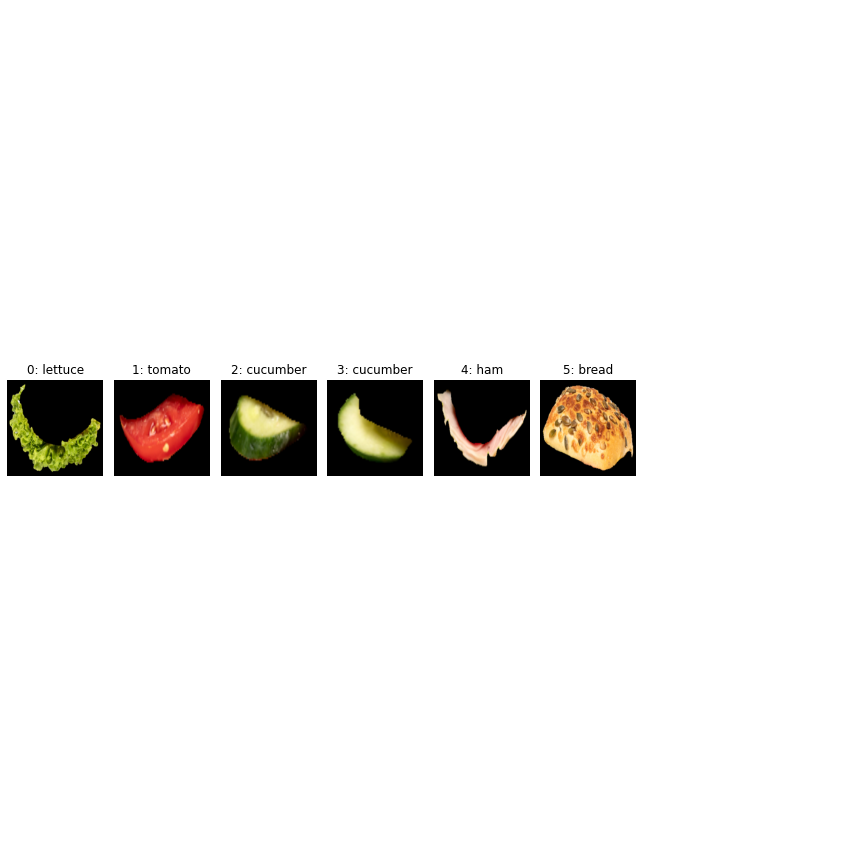

In [9]:
# Allow the user to modify classification
prompt = f"""Would you like to redefine any of the masks?\n
Input them in the format '0:apple 5:pear 12:banana' (if any):\n"""
answer = input(prompt).lower()
answer = [element for element in answer.split(" ")]

fig, axes = plt.subplots(grid_length, 8, figsize=(12, 12))

for element in answer:
    index, category = element.split(":")
    predictions[int(index)] = category

for index, ax in enumerate(axes.reshape(-1)): 
    if index >= len(segmented_images):
        ax.set_axis_off()
        continue
        
    ax.set_title(f"{index}: {predictions[index]}")
    ax.set_axis_off()
    ax.imshow(segmented_images[index])

fig.tight_layout()
plt.show()

#### 6. Verify correctness of weight estimates

**Let's say we are interested in prediction per 100 grams, so no changes here.**

In [10]:
# Use pixel-counting with SAM to estimate areas (not volumes)
metadata = pd.read_csv(f"{mask_path}metadata.csv")

ids = metadata["id"].tolist()
areas = metadata["area"].tolist()

counts = {}
total_count = 0

for i, (new_id, old_id) in enumerate(mask_map.items()):
    pixel_count = areas[ids[old_id]]
    
    if predictions[new_id] not in counts:
        counts[predictions[new_id]] = {"area": 0}
    counts[predictions[new_id]]["area"] += pixel_count
    total_count += pixel_count
    
for item in counts:
    counts[item]["proportion"] = counts[item]["area"] / total_count

# Allow user to estimate weight of the dish
prompt = f"""Would you like to receive an estimate per 100 grams?\n
Type 'y' or provide estimated portion size (in grams):\n"""
answer = input(prompt).lower()

weight = 100
if answer != "y":
    weight = int(answer)

print(f"\nEstimates:")
for item in counts:
    counts[item]["estimated_weight"] = int(counts[item]['proportion'] * weight)
    print(f"    {item}: {counts[item]['estimated_weight']} grams")

Would you like to receive an estimate per 100 grams?

Type 'y' or provide estimated portion size (in grams):
y

Estimates:
    lettuce: 33 grams
    tomato: 6 grams
    cucumber: 6 grams
    ham: 7 grams
    bread: 46 grams


**The lettuce looks a bit too heavy so we will assign a new weight (our estimates are by area not density)**

In [13]:
# Allow user to modify weight estimates from counted pixels
prompt = f"""Would you like to modify any of the estimated weights?\n
Input these in the format 'apple:100 pear:80 banana:100' (if any):\n"""
answer = input(prompt).split(" ")

for element in answer:
    item, weight = element.split(":")
    counts[item]["estimated_weight"] = weight

print(f"\nEstimates:")
for item in counts:
    print(f"    {item}: {counts[item]['estimated_weight']} grams")

Would you like to modify any of the estimated weights?

Input these in the format 'apple:100 pear:80 banana:100' (if any):
lettuce:10

Estimates:
    lettuce: 10 grams
    tomato: 6 grams
    cucumber: 6 grams
    ham: 7 grams
    bread: 46 grams


### 7. Get nutritional value estimate

In [14]:
# Look up each ingredient in the USDA database and combine into a single profile
api_key = get_api_key()
profile = {}

for item in counts:
    response = json.loads(requests.get('https://api.nal.usda.gov/fdc/v1/foods/search?api_key={}&query={}'.format(api_key, item)).text)
    nutrients = response["foods"][0]["foodNutrients"]
    for nutrient in nutrients:
        if nutrient["nutrientName"] not in profile:
            profile[nutrient["nutrientName"]] = {"value": 0, "unit": nutrient["unitName"]}
            
        multiplier = int(counts[item]["estimated_weight"]) / 100
        profile[nutrient["nutrientName"]]["value"] += float(nutrient["value"]) * multiplier
        
print(f"Nutritional Value Estimate for: {file_name}")
for nutrient in profile:
    print(f"    {nutrient} | {np.round(profile[nutrient]['value'], 2)} {profile[nutrient]['unit']}")

Nutritional Value Estimate for: sandwich
    Protein | 5.1 G
    Total lipid (fat) | 0.29 G
    Carbohydrate, by difference | 26.27 G
    Energy | 132.61 KCAL
    Alcohol, ethyl | 0.0 G
    Water | 19.96 G
    Caffeine | 0.0 MG
    Theobromine | 0.0 MG
    Sugars, total including NLEA | 0.57 G
    Fiber, total dietary | 1.35 G
    Calcium, Ca | 4.1 MG
    Iron, Fe | 0.57 MG
    Magnesium, Mg | 3.0 MG
    Phosphorus, P | 22.92 MG
    Potassium, K | 50.15 MG
    Sodium, Na | 350.94 MG
    Zinc, Zn | 0.15 MG
    Copper, Cu | 0.01 MG
    Selenium, Se | 2.42 UG
    Retinol | 0.91 UG
    Vitamin A, RAE | 20.89 UG
    Carotene, beta | 238.62 UG
    Carotene, alpha | 0.62 UG
    Vitamin E (alpha-tocopherol) | 0.04 MG
    Vitamin D (D2 + D3) | 0.05 UG
    Cryptoxanthin, beta | 0.96 UG
    Lycopene | 0.0 UG
    Lutein + zeaxanthin | 100.84 UG
    Vitamin C, total ascorbic acid | 0.75 MG
    Thiamin | 0.04 MG
    Riboflavin | 0.02 MG
    Niacin | 0.45 MG
    Vitamin B-6 | 0.04 MG
    Folate, tota